# Summary

Rating models can give us a good comparison of the relative strength of different climbers. However, some climbers might have different skills/specialties (e.g more powerful, more technical, more flexible), and so they might excel at particular types of boulders. To identify these specialties, we need to build a multi-dimensional representation for each climber (AKA a vector embedding).

Unfortunately, we don't have any information about the attributes of each boulder (e.g. we don't know that a given boulder is very technical). Therefore, we will have to learn these multi-dimensional representations automatically from the data. One way to do this is with probabilistic matrix factorization (PMF), a technique commonly used for recommender systems.

The goal is to learn representations with probabilistic matrix factorization, and show that: (A) these representations are more predictive than a benchmark rating model/unidimensional representation (B) the multidimensional embeddings capture some aspect of climber specialties (we need some domain knowledge to validate this). For the benchmark model, I suggest a generalized linear model with climber coefficients.


## Possibly relevant literature

Interesting blog on modelling amateur climbers: https://www.ethanrosenthal.com/2022/04/15/bayesian-rock-climbing/

Analysis whose data we're using: https://davidbreuer.github.io/ifsc-analysis/

## Data Preparation

In [84]:
import pandas as pd
import numpy as np 
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns 
from patsy import dmatrix

from sksurv.linear_model import CoxnetSurvivalAnalysis 
from sksurv.linear_model import CoxPHSurvivalAnalysis 

from sksurv.util import Surv



Import data

In [13]:
url =  "https://github.com/DavidBreuer/ifsc-analysis/raw/main/ifsc_Boulder.xlsx"
df = pd.read_excel(url)
df

,Unique,Year,Discipline,Competition,Gender,Level,Group,Name,Number,Country,...,Zone4,Top5,Zone5,Route1,Route2,Run1,Run2,Run3,Run4,Run5
0,2007;Boulder;Boulder IFSC Climbing Worldcup (B...,2007,Boulder,Boulder IFSC Climbing Worldcup (B) - Erlangen ...,M,Q,Result,Stéphan Julien,32,FRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007;Boulder;Boulder IFSC Climbing Worldcup (B...,2007,Boulder,Boulder IFSC Climbing Worldcup (B) - Erlangen ...,M,Q,Result,Gareth Parry,26,GBR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007;Boulder;Boulder IFSC Climbing Worldcup (B...,2007,Boulder,Boulder IFSC Climbing Worldcup (B) - Erlangen ...,M,Q,Result,Nalle Hukkataival,10,FIN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007;Boulder;Boulder IFSC Climbing Worldcup (B...,2007,Boulder,Boulder IFSC Climbing Worldcup (B) - Erlangen ...,M,Q,Result,Gérome Pouvreau,36,FRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007;Boulder;Boulder IFSC Climbing Worldcup (B...,2007,Boulder,Boulder IFSC Climbing Worldcup (B) - Erlangen ...,M,Q,Result,Jorg Verhoeven,27,NED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19431,2022;Boulder;Boulder • Lead IFSC - Climbing Wo...,2022,Boulder,"Boulder • Lead IFSC - Climbing World Cup (B,L)...",W,F,Result,Hannah Meul,6,GER,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19432,2022;Boulder;Boulder • Lead IFSC - Climbing Wo...,2022,Boulder,"Boulder • Lead IFSC - Climbing World Cup (B,L)...",W,F,Result,Miho Nonaka,52,JPN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19433,2022;Boulder;Boulder • Lead IFSC - Climbing Wo...,2022,Boulder,"Boulder • Lead IFSC - Climbing World Cup (B,L)...",W,F,Result,Futaba Ito,3,JPN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19434,2022;Boulder;Boulder • Lead IFSC - Climbing Wo...,2022,Boulder,"Boulder • Lead IFSC - Climbing World Cup (B,L)...",W,F,Result,CHAEHYUN SEO,8,KOR,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Clean data

In [25]:
# Get rid of columns we don't need
data_clean = df.drop(columns=[col for col in df.columns if col in ['Unique', 'Discipline', 'Number'] or 'Route' in col or 'Run' in col])

# Capitalize climber names consistently 
data_clean['Name'] = data_clean['Name'].str.title()

# "Unpivot" so it's one row per climber-problem
# I'm treating tops and zones as separate problems even though there's obviously a correlation
data_clean = pd.melt(data_clean, id_vars=[col for col in data_clean.columns if col not in ['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Zone1', 'Zone2', 'Zone3', 'Zone4', 'Zone5']], value_vars=['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Zone1', 'Zone2', 'Zone3', 'Zone4', 'Zone5'], var_name='problem', value_name='attempts')
data_clean = data_clean.dropna()
data_clean['attempts'] = data_clean['attempts'].replace([np.inf, -np.inf], np.nan)

data_clean['attempts'] = data_clean['attempts'].astype('Int64')

# Keeping only guys for now
data_clean = data_clean[data_clean["Gender"] == 'M']
# Only keep boulders that at least one climber topped
data_clean = data_clean.groupby(['Competition', 'Level', 'problem']).filter(lambda x: x['attempts'].notnull().any())

# For anyone who failed to top the climb, we'll set their number of attempts to whatever
# # the maximum observed number of attempts was for that climb
data_clean['max_attempts'] = data_clean.groupby(['Competition', 'Level', 'problem'])['attempts'].transform('max')

#Survival model features
data_clean['status'] = data_clean['attempts'].notnull() #1 if topped, 0 if not
data_clean['time'] = data_clean.apply(lambda row: row['max_attempts'] if pd.isnull(row['attempts']) else row['attempts'], axis=1) #if topped, time is number of attempts, if not topped, time is max number of attempts

# Keep climber name only for climbers with lots of data, use "Other" as replacement level
less_than = data_clean.groupby('Name')['Name'].transform('size') >= 1000
data_clean['climber'] = data_clean['Name'].where(less_than, 'Other')
data_clean.reset_index()

In [65]:
data_clean['attempts'].isna().sum() #sanity check

AttributeError: 'numpy.int64' object has no attribute 'reset_index'

## Basic Survival Models


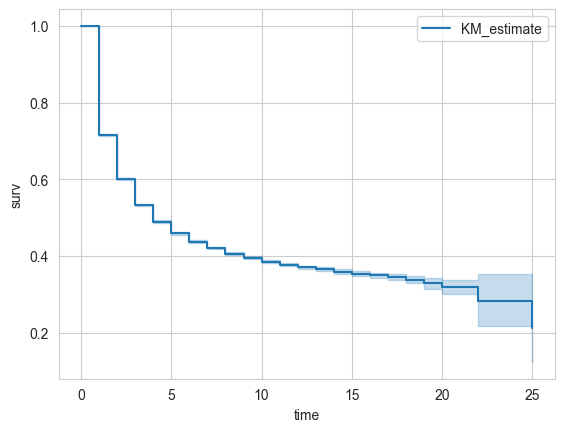

          KM_estimate
timeline             
0.0          1.000000
1.0          0.714839
2.0          0.600526
3.0          0.533231
4.0          0.489423
5.0          0.458682
6.0          0.437061
7.0          0.420428
8.0          0.405556
9.0          0.395093
10.0         0.385363
11.0         0.377079
12.0         0.369899
13.0         0.364958
14.0         0.359089
15.0         0.353803
16.0         0.349891
17.0         0.344424
18.0         0.337736
19.0         0.328267
20.0         0.318752
22.0         0.283335
25.0         0.212501


In [46]:
# I tried doing this with scikit-survival but couldn't get it
kmf_fit = KaplanMeierFitter()
kmf_fit.fit(data_clean['time'], event_observed=data_clean['status'])

sns.set_style("whitegrid") #use this to make it less ugly

kmf_fit.plot_survival_function()
plt.xlabel('time')
plt.ylabel('surv')
plt.show()
print(f"{kmf_fit.survival_function_}")

Add climber effects

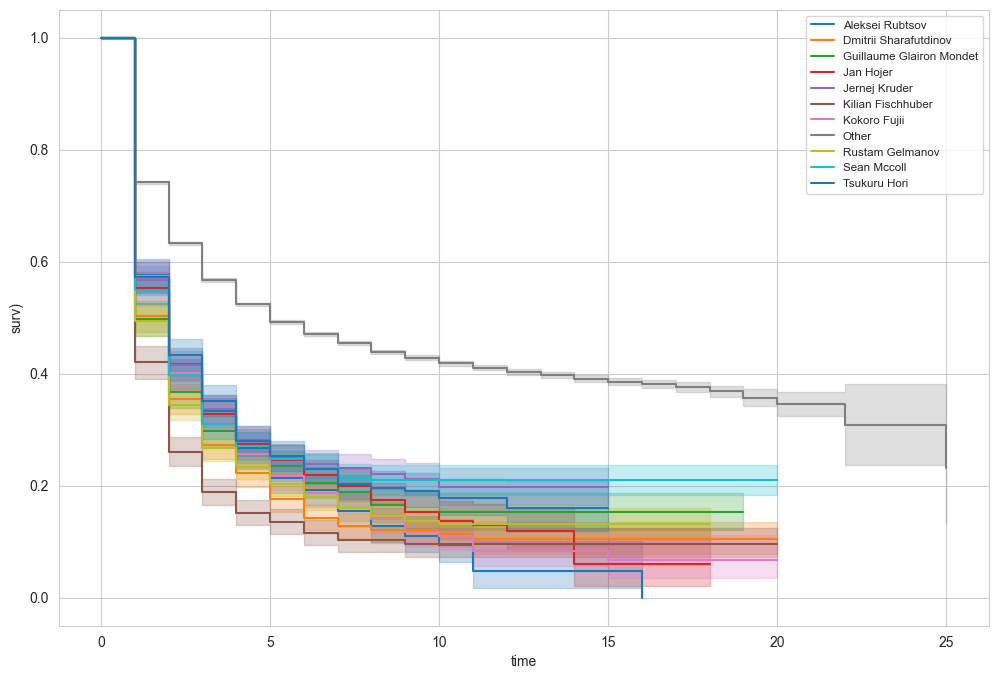

In [53]:
kmf_fit2 = KaplanMeierFitter()

for climber, data in data_clean.groupby('climber'): #organize by climbers, and get each climbers data
    kmf_fit2.fit(data['time'], event_observed=data['status'], label=climber)
    kmf_fit2.plot_survival_function(figsize = (12, 8))

plt.xlabel('time')
plt.ylabel('surv)')
plt.legend(loc='best', fontsize='small')
plt.show()#Not the same color coding but oh well

Add level effects:

In [57]:
cox_fit = CoxPHFitter()
cox_fit.fit(data_clean, duration_col = 'time', event_col='status',formula='Level + climber')
print(cox_fit.summary) #this does not give the right summary but oh well coefs are the same 


                                         coef  exp(coef)  se(coef)  \
covariate                                                            
Level[T.Q]                          -0.197752   0.820573  0.019723   
Level[T.S]                          -0.125289   0.882242  0.021039   
climber[T.Dmitrii Sharafutdinov]     0.139170   1.149320  0.046749   
climber[T.Guillaume Glairon Mondet]  0.063600   1.065667  0.048446   
climber[T.Jan Hojer]                 0.004245   1.004254  0.048208   
climber[T.Jernej Kruder]            -0.039260   0.961501  0.046585   
climber[T.Kilian Fischhuber]         0.316958   1.372945  0.047331   
climber[T.Kokoro Fujii]              0.021928   1.022170  0.047866   
climber[T.Other]                    -0.656707   0.518556  0.035238   
climber[T.Rustam Gelmanov]           0.118304   1.125586  0.046062   
climber[T.Sean Mccoll]              -0.017550   0.982603  0.047085   
climber[T.Tsukuru Hori]             -0.053536   0.947872  0.048297   

                   

## Regularized Survival Models
We may want to eventually add regularization, especially for the climber coefficients (for example to penalize low-sample size players more). We can do this in R with the `glmnet` package. See glmnet instructions at https://glmnet.stanford.edu/articles/Coxnet.html. I'm not as familiar with doing generalized linear models in Python but there should be a way to do it (sklearn?).


In [82]:
# Make the X = model.matrix(~ climber + Level, data = data_clean) line
# creates a matrix with the columns of the data_clean dataframe using formula = 'climber + Level',
# use the patsy library
X = dmatrix(formula_like='climber + Level', data=data_clean, return_type='matrix')
y = Surv.from_dataframe("status", "time", data_clean) 

coxnet = CoxnetSurvivalAnalysis(l1_ratio = 0.5) #Here we use the CoxnetSurvivalAnalysis function from the sksurv library because it regularizes whereas lifelines doesn't, as well as the CoxPHSurivalAnalysis one but lifelines was easier to use :(
#alpha controls balance between L1 and L2 regression --> equivalent to l1_ratio in sklearn's model
coxnet.fit(X, y)

CoxnetSurvivalAnalysis()

This source was helpful for me (Victor) to understand this a bit more https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html

In [91]:
y

array([( True,  1.), ( True,  1.), ( True,  1.), ..., (False, 11.),
       (False, 11.), (False, 11.)],
      dtype=[('status', '?'), ('time', '<f8')])

ValueError: x and y must have same first dimension, but have shapes (6,) and (13, 6)

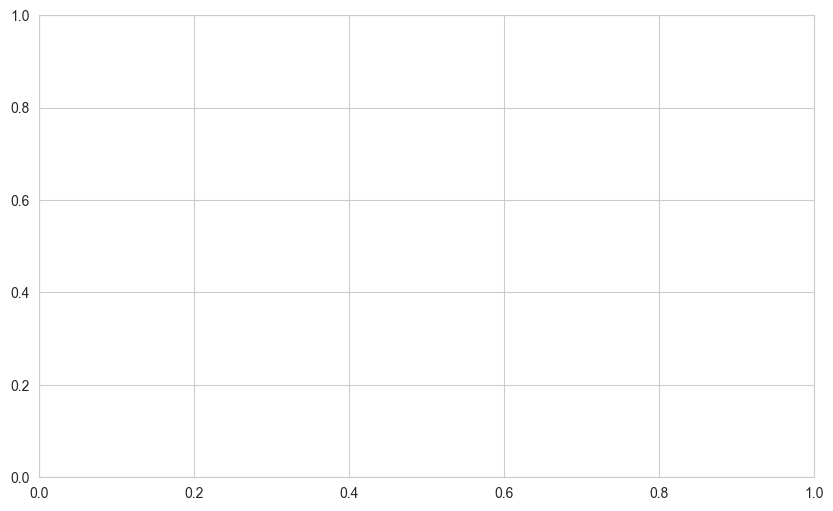

In [89]:
X_df = dmatrix(formula_like='climber + Level', data=data_clean, return_type='dataframe')
plt.figure(figsize=(10, 6))
plt.plot(-np.log(coxnet.alphas_), coxnet.coef_)
plt.xlabel('-log(alpha)')
plt.ylabel('Coefficients')
plt.title('Coefficient Paths')
plt.show()

Some ideas of features we can include:

- Figure out how strong the competition is (are there levels/divisions?)
- Add aging effects or Player:Year coefficients
- Maybe the month is relevant (e.g. do people peak for different parts of the season?)

# Matrix Factorization Models

Read about probabilistic matrix factorization. The original paper is at https://proceedings.neurips.cc/paper_files/paper/2007/file/d7322ed717dedf1eb4e6e52a37ea7bcd-Paper.pdf but you can try to find a blog that will be more accessible.

You can adapt my Python keras implementation for bike2vec from here: https://github.com/baronet2/Bike2Vec/blob/main/notebooks/pcs_worldtour_00_direct_embeddings.ipynb. I didn't know it at the time but I was basically doing PMF. The main difference for us is to change the loss function to be binary classification (success/fail) or a survival model (number of attempts).

Maybe check out this recsys extension of PyTorch: https://github.com/maciejkula/spotlight. They might have a PMF implementation we can use.

# Train/Test Split

We need to ensure that for every climber/climb in the testing dataset we also have some data in the training dataset (otherwise we won't be able to learn their embeddings). Ideally we can compare the test log likelihood betweeen PMF and the glm survival model.

Since 2020 has much less data (COVID) if we're doing anything with Year as a variable we may need to be careful with that.
